### Burst statistics

In [1]:
import sys

sys.path.insert(1, "/home/vinicius/storage1/projects/vanderbilt")

In [2]:
import os

import emd
import igraph as ig
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import PyEMD
import scipy
import skimage as ski
import umap
import xarray as xr
from frites.conn.conn_sliding_windows import define_windows
from frites.utils import parallel_func
from mne.time_frequency import tfr_array_morlet
from scipy.optimize import curve_fit
from skimage.segmentation import watershed
from tqdm import tqdm
from functools import partial
import jax
import jax.numpy as jnp
from config import metadata
from VUDA.emd import emd_vec
from VUDA.io.loadbinary import LoadBinary
import seaborn as sns

/home/vinicius/anaconda3/envs/ipp/lib/python3.9/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/vinicius/anaconda3/envs/ipp/lib/python3.9/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/vinicius/anaconda3/envs/ipp/lib/python3.9/site-packages/umap/distanc

#### Functions

In [3]:
def replace_zeros_with_nan(arr):
    """
    Replaces zeros in a JAX array with NaNs.

    Parameters:
        arr (jax.numpy.ndarray): Input array.

    Returns:
        jax.numpy.ndarray: Array with zeros replaced by NaNs.
    """
    return jnp.where(arr == 0, jnp.nan, arr)

@partial(jax.vmap, in_axes=(None, 0))
def get_n_channels(labels: np.ndarray, label: int):
    """
    Calculates the maximum number of channels associated with a given label.

    Parameters:
        labels (numpy.ndarray): Array of labels.
        label (int): Label to compute channels for.

    Returns:
        int: Maximum number of channels associated with the given label.
    """
    return (labels == label).sum(0).max()

def nonzeromean(data: np.ndarray):
    """
    Computes the mean of non-zero elements in the input array.

    Parameters:
        data (numpy.ndarray): Input array.

    Returns:
        float: Mean of non-zero elements.
    """
    return data.sum() / (jnp.abs(data) > 0).sum()

def nonzerostd(data: np.ndarray):
    """
    Computes the standard deviation of non-zero elements in the input array.

    Parameters:
        data (numpy.ndarray): Input array.

    Returns:
        float: Standard deviation of non-zero elements.
    """
    non_zero_elements = data[data != 0]
    mean = non_zero_elements.mean()
    variance = ((non_zero_elements - mean) ** 2).mean()
    std_dev = np.sqrt(variance)
    return std_dev

def get_masked_feature(vector: np.ndarray, labels: np.ndarray, label: int):
    """
    Masks the feature vector based on the given label.

    Parameters:
        vector (numpy.ndarray): Feature vector.
        labels (numpy.ndarray): Array of labels.
        label (int): Label to mask the feature vector.

    Returns:
        numpy.ndarray: Masked feature vector.
    """
    return ((labels == label) * vector)

@partial(jax.vmap, in_axes=(None, None, 0))
def average_feature(vector: np.ndarray, labels: np.ndarray, label: int):
    """
    Computes the average of non-zero elements in the masked feature vector, replacing zeros with NaNs.

    Parameters:
        vector (numpy.ndarray): Feature vector.
        labels (numpy.ndarray): Array of labels.
        label (int): Label to compute the average for.

    Returns:
        float: Average of non-zero elements in the masked feature vector.
    """
    masked = get_masked_feature(vector, labels, label)
    return jnp.nanmean(replace_zeros_with_nan(masked))

@partial(jax.vmap, in_axes=(None, None, 0))
def spread_feature(vector: np.ndarray, labels: np.ndarray, label: int):
    """
    Computes the standard deviation of non-zero elements in the masked feature vector, replacing zeros with NaNs.

    Parameters:
        vector (numpy.ndarray): Feature vector.
        labels (numpy.ndarray): Array of labels.
        label (int): Label to compute the standard deviation for.

    Returns:
        float: Standard deviation of non-zero elements in the masked feature vector.
    """
    masked = get_masked_feature(vector, labels, label)
    return jnp.nanstd(replace_zeros_with_nan(masked))

@partial(jax.vmap, in_axes=(None, None, 0))
def get_duration(times: np.ndarray, labels: np.ndarray, label: int):
    """
    Computes the duration of a particular label based on the provided times.

    Parameters:
        times (numpy.ndarray): Array of times.
        labels (numpy.ndarray): Array of labels.
        label (int): Label to compute the duration for.

    Returns:
        float: Duration of the label.
    """
    arr = get_masked_feature(times[None, :], labels, label)
    arr = replace_zeros_with_nan(arr)
    _min = jnp.nanmin(arr)
    _max = jnp.nanmax(arr)
    return _max - _min

@partial(jax.vmap, in_axes=(None, None, 0))
def get_spatial_spread(nchannels: int, labels: np.ndarray, label: int):
    """
    Computes the spatial spread of a particular label.

    Parameters:
        nchannels (int): Number of channels.
        labels (numpy.ndarray): Array of labels.
        label (int): Label to compute the spatial spread for.

    Returns:
        numpy.ndarray: Array containing the minimum and maximum channel indices.
    """
    out = jnp.nonzero((labels == label).sum((1, 2)), size=nchannels, fill_value=jnp.nan)[0]
    ci, cf = jnp.nanmin(out), jnp.nanmax(out)
    return jnp.array([ci, cf], dtype=jnp.int16)

In [4]:
import numba as nb
import numpy as np
import xarray as xr
from skimage import measure as ski


def arrays_equal(a, b):
    """
    Check if two arrays are equal.

    Parameters:
    - a (numpy.ndarray): First array.
    - b (numpy.ndarray): Second array.

    Returns:
    - bool: True if the arrays are equal, False otherwise.

    This function checks whether two arrays are equal by comparing their shapes
    and element-wise values.
    """
    if a.shape != b.shape:
        return False
    for ai, bi in zip(a.flat, b.flat):
        if ai != bi:
            return False
    return True


def return_labeled_image(img: np.ndarray = None, threshold: float = None):
    """
    Label regions in a binary image using a given threshold.

    Parameters:
    - img (numpy.ndarray): The binary image to label.
    - threshold (float): The threshold for labeling.

    Returns:
    - numpy.ndarray: A labeled image with connected regions.
    - numpy.ndarray: Array of unique labels.
    - int: The number of unique labels.

    This function labels connected regions in a binary image based on a given threshold.
    It uses the `ski.measure.label` function from the scikit-image library to perform
    the labeling. The resulting labeled image contains connected regions with unique
    labels, and the number of labels is also returned.
    """
    labeled_image = ski.label(img > threshold, background=0)
    labels = np.unique(labeled_image)[1:]
    nlabels = len(labels)
    return labeled_image, labels, nlabels


def detect_bursts(
    spectra: xr.DataArray,
    init_threshold: float = None,
    min_threshold: float = 0,
    gamma: float = 1,
    zscore_dims: tuple = None,
):
    """
    Detect bursts in spectra using a dynamic thresholding approach.

    Parameters:
    - spectra (xarray.DataArray): The input spectra to analyze.
    - init_threshold (float): The initial threshold for labeling. If none uses the floor
                              of the maximum value in the zsored data.
    - min_threshold (float): The minimum threshold to stop the labeling process.
    - gamma (float): The step size for updating the threshold.
    - zscore_dims (tuple): Dimensions along which to compute z-scores.

    Returns:
    - numpy.ndarray: An image with labeled bursts.

    This function detects bursts in a given spectra by iteratively updating a labeling
    based on threshold values. It starts with an initial threshold, and in each iteration,
    it updates the labeling using a lower threshold. The process continues until the
    threshold reaches the minimum threshold value. The resulting labeled image contains
    burst regions.

    Note: The input spectra are first z-scored before applying labeling.
    """

    size = spectra.shape
    z = (spectra - spectra.mean(zscore_dims)) / spectra.std(zscore_dims)
    return_labeled_image_partial = partial(return_labeled_image, img=z)

    if init_threshold is None:
        init_threshold = int(z.max(zscore_dims).min())  # int(np.max(z))

    labeled_image, labels, nlabels = return_labeled_image(z, init_threshold)
    thr = init_threshold - gamma

    while thr >= min_threshold:
        new_labeled_image, new_labels, new_nlabels = return_labeled_image_partial(
            threshold=thr
        )

        indexes = np.zeros(new_labeled_image.shape, dtype=np.bool_)

        for label in new_labels:
            mask = new_labeled_image == label
            unique_labels = np.unique(mask * labeled_image)
            if len(unique_labels) > 2:
                indexes = np.logical_or(indexes, mask)

        not_indexes = np.logical_not(indexes)
        new_labeled_image = new_labeled_image * not_indexes + labeled_image * indexes

        old_labeled_image = labeled_image.copy()

        labeled_image, labels, nlabels = return_labeled_image(new_labeled_image, 0)

        # Break if there is no evolution of patches
        if arrays_equal(labeled_image, old_labeled_image):
            break

        del old_labeled_image

        thr -= gamma

    return labeled_image

#### Load data

In [5]:
date = "10-20-2022"
monkey = "FN"
max_imfs = None
method = "eemd"

base_path = os.path.expanduser(f"~/funcog/HoffmanData/{monkey}/{date}")

composites_path = os.path.join(
    base_path, "composite_signals_task_method_eemd_max_imfs_None_std_False.nc"
)

ps_composites_path = os.path.join(
    base_path, "ps_composite_signals_task_method_eemd_max_imfs_None_std_False.nc"
)

In [6]:
composites = xr.open_dataset(composites_path)
ps_composites = xr.open_dataset(ps_composites_path)

In [7]:
channels = list(composites.keys())

#### Load burts - single channel

In [8]:
def load_bursts(channel: str = None, rythm: str = "slow"):
    assert rythm in ["slow", "fast"]
    _base = os.path.join(base_path, "bursts")
    fname = (
        f"labeled_bursts_{rythm}_{channel}_task_method_eemd_max_imfs_None_std_False.nc"
    )
    fname = os.path.join(_base, fname)
    return xr.load_dataarray(fname)

In [9]:
bursts = (load_bursts(channel="channel31", rythm="fast")).astype(int)

In [10]:
nblocks, nfreqs, ntimes = bursts.shape

In [11]:
features = []

for i in tqdm(range(nblocks)):

    times = bursts[i].times.data
    freqs = bursts[i].freqs.data

    unique_labels = np.unique(bursts[i])[1:]

    get_average_time = partial(average_feature, times)
    get_average_freq = partial(average_feature, freqs[:, None])

    get_std_time = partial(spread_feature, times)
    get_std_freq = partial(spread_feature, freqs[:, None])

    fvec = [
        get_average_time(bursts[i].data, unique_labels),
        get_std_time(bursts[i].data, unique_labels),
        get_duration(times, bursts[i].data, unique_labels),
        get_average_freq(bursts[i].data, unique_labels),
        get_std_freq(bursts[i].data, unique_labels),
    ]
    features.append(fvec)

features = np.hstack(features)

100%|███████████████████████████████████████████████████████| 200/200 [01:56<00:00,  1.71it/s]


In [13]:
feature_names = ["avg. time", "std. time", "duration", "avg. freq", "std. freq"]

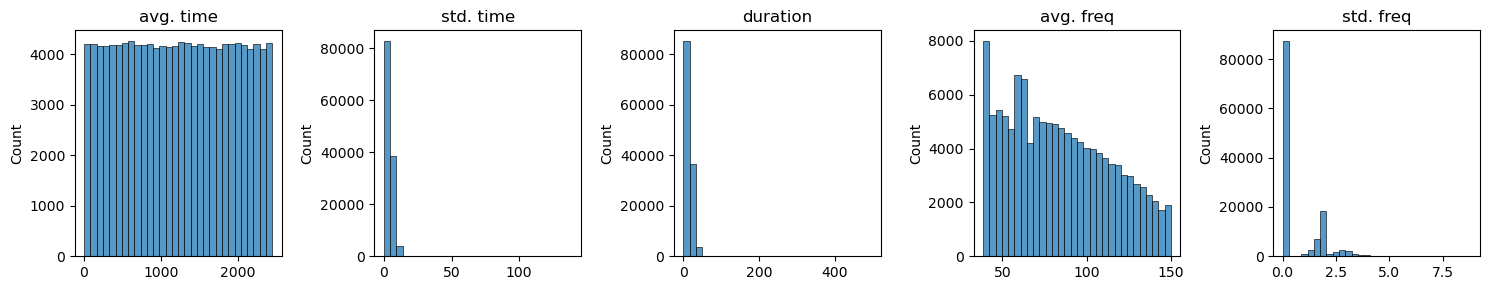

In [14]:
plt.figure(figsize=(15, 3))
for i in range(len(features)):
    plt.subplot(1, len(features), i + 1)
    sns.histplot(data=features[i], bins=30)
    plt.title(feature_names[i])
plt.tight_layout()

#### Load burts - all channels

In [15]:
def get_features(channel: str, rythm: str) -> np.ndarray:

    bursts = (load_bursts(channel=channel, rythm=rythm)).astype(int)

    nblocks, nfreqs, ntimes = bursts.shape

    features = []

    for i in range(nblocks):

        times = bursts[i].times.data
        freqs = bursts[i].freqs.data

        unique_labels = np.unique(bursts[i])[1:]

        get_average_time = partial(average_feature, times)
        get_average_freq = partial(average_feature, freqs[:, None])

        get_std_time = partial(spread_feature, times)
        get_std_freq = partial(spread_feature, freqs[:, None])

        fvec = [
            get_average_time(bursts[i].data, unique_labels),
            get_std_time(bursts[i].data, unique_labels),
            get_duration(times, bursts[i].data, unique_labels),
            get_average_freq(bursts[i].data, unique_labels),
            get_std_freq(bursts[i].data, unique_labels),
        ]
        features.append(fvec)

    return np.hstack(features)

In [16]:
features_slow = [get_features(channel=channel, rythm="slow") for channel in tqdm(channels)]

100%|█████████████████████████████████████████████████████████| 40/40 [04:08<00:00,  6.21s/it]


In [57]:
features_fast = [get_features(channel=channel, rythm="fast") for channel in tqdm(channels)]

100%|█████████████████████████████████████████████████████████| 40/40 [35:56<00:00, 53.90s/it]


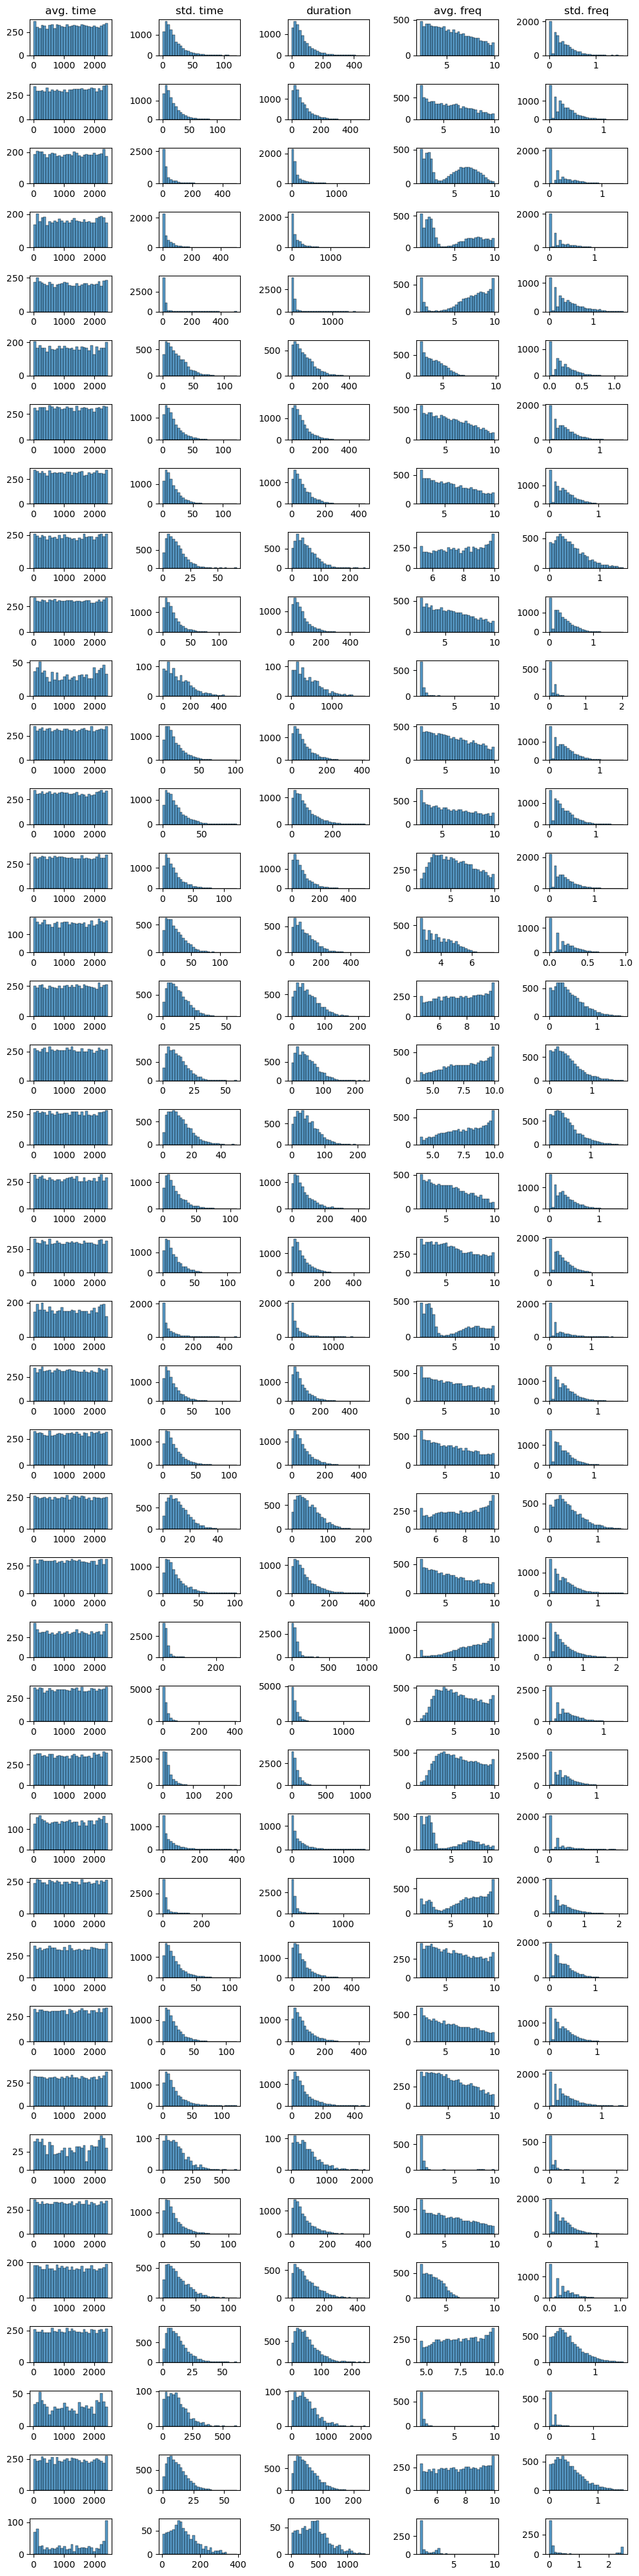

In [17]:
plt.figure(figsize=(10, 40))
pos = 1
for c in range(len(features_slow)):
    for i in range(len(features)):
        plt.subplot(40, len(features), pos)
        sns.histplot(data=features_slow[c][i], bins=30)
        if c == 0:
            plt.title(feature_names[i])
        plt.ylabel("")
        pos = pos + 1
plt.tight_layout()

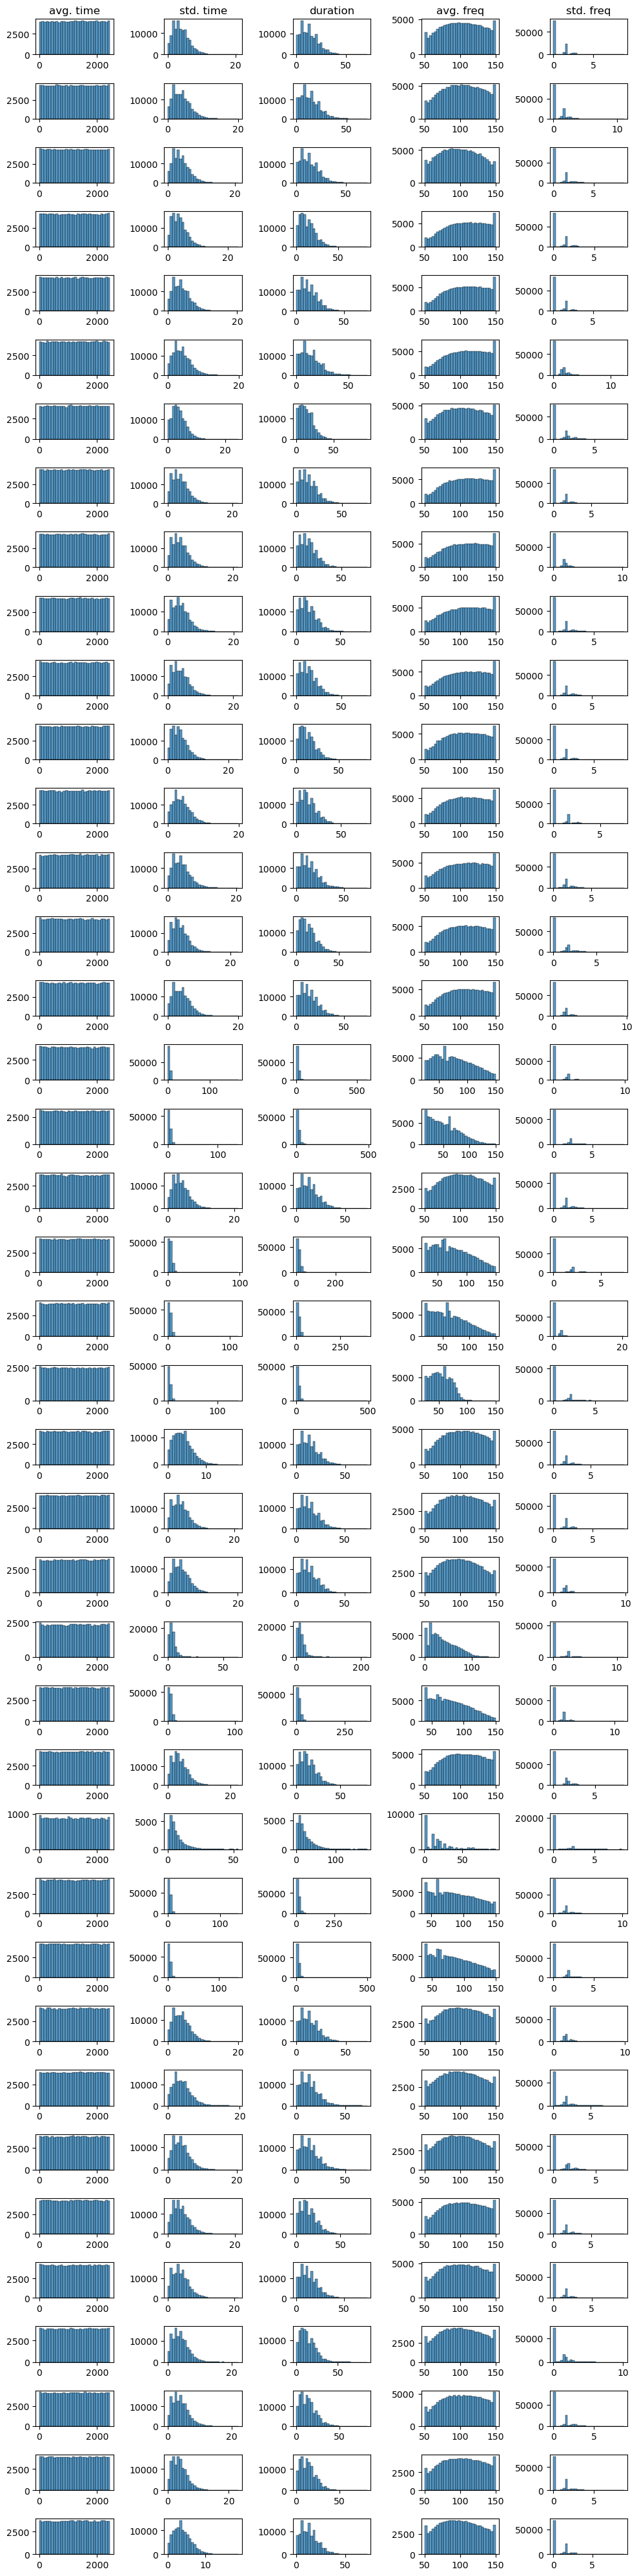

In [58]:
plt.figure(figsize=(10, 40))
pos = 1
for c in range(len(features_slow)):
    for i in range(len(features)):
        plt.subplot(40, len(features), pos)
        sns.histplot(data=features_fast[c][i], bins=30)
        if c == 0:
            plt.title(feature_names[i])
        plt.ylabel("")
        pos = pos + 1
plt.tight_layout()

In [18]:
features_slow_stacked = np.hstack(features_slow)

In [59]:
features_fast_stacked = np.hstack(features_fast)

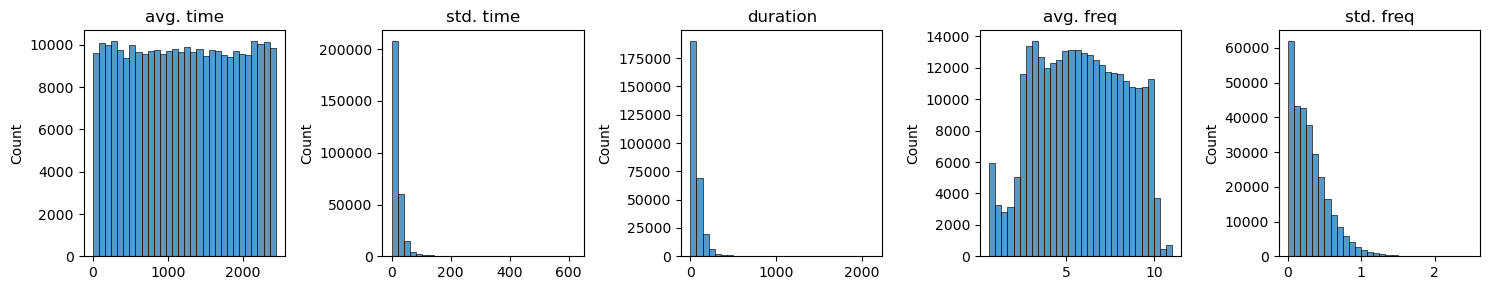

In [19]:
plt.figure(figsize=(15, 3))
for i in range(len(features)):
    plt.subplot(1, len(features), i + 1)
    sns.histplot(data=features_slow_stacked[i], bins=30)
    plt.title(feature_names[i])
plt.tight_layout()

In [25]:
data = features_slow_stacked[[2, 3]].T

In [26]:
colors = []
for i in range(1, 41):
    colors += [ [i] * features_slow[i - 1].shape[1] ]
colors = np.concatenate(colors)

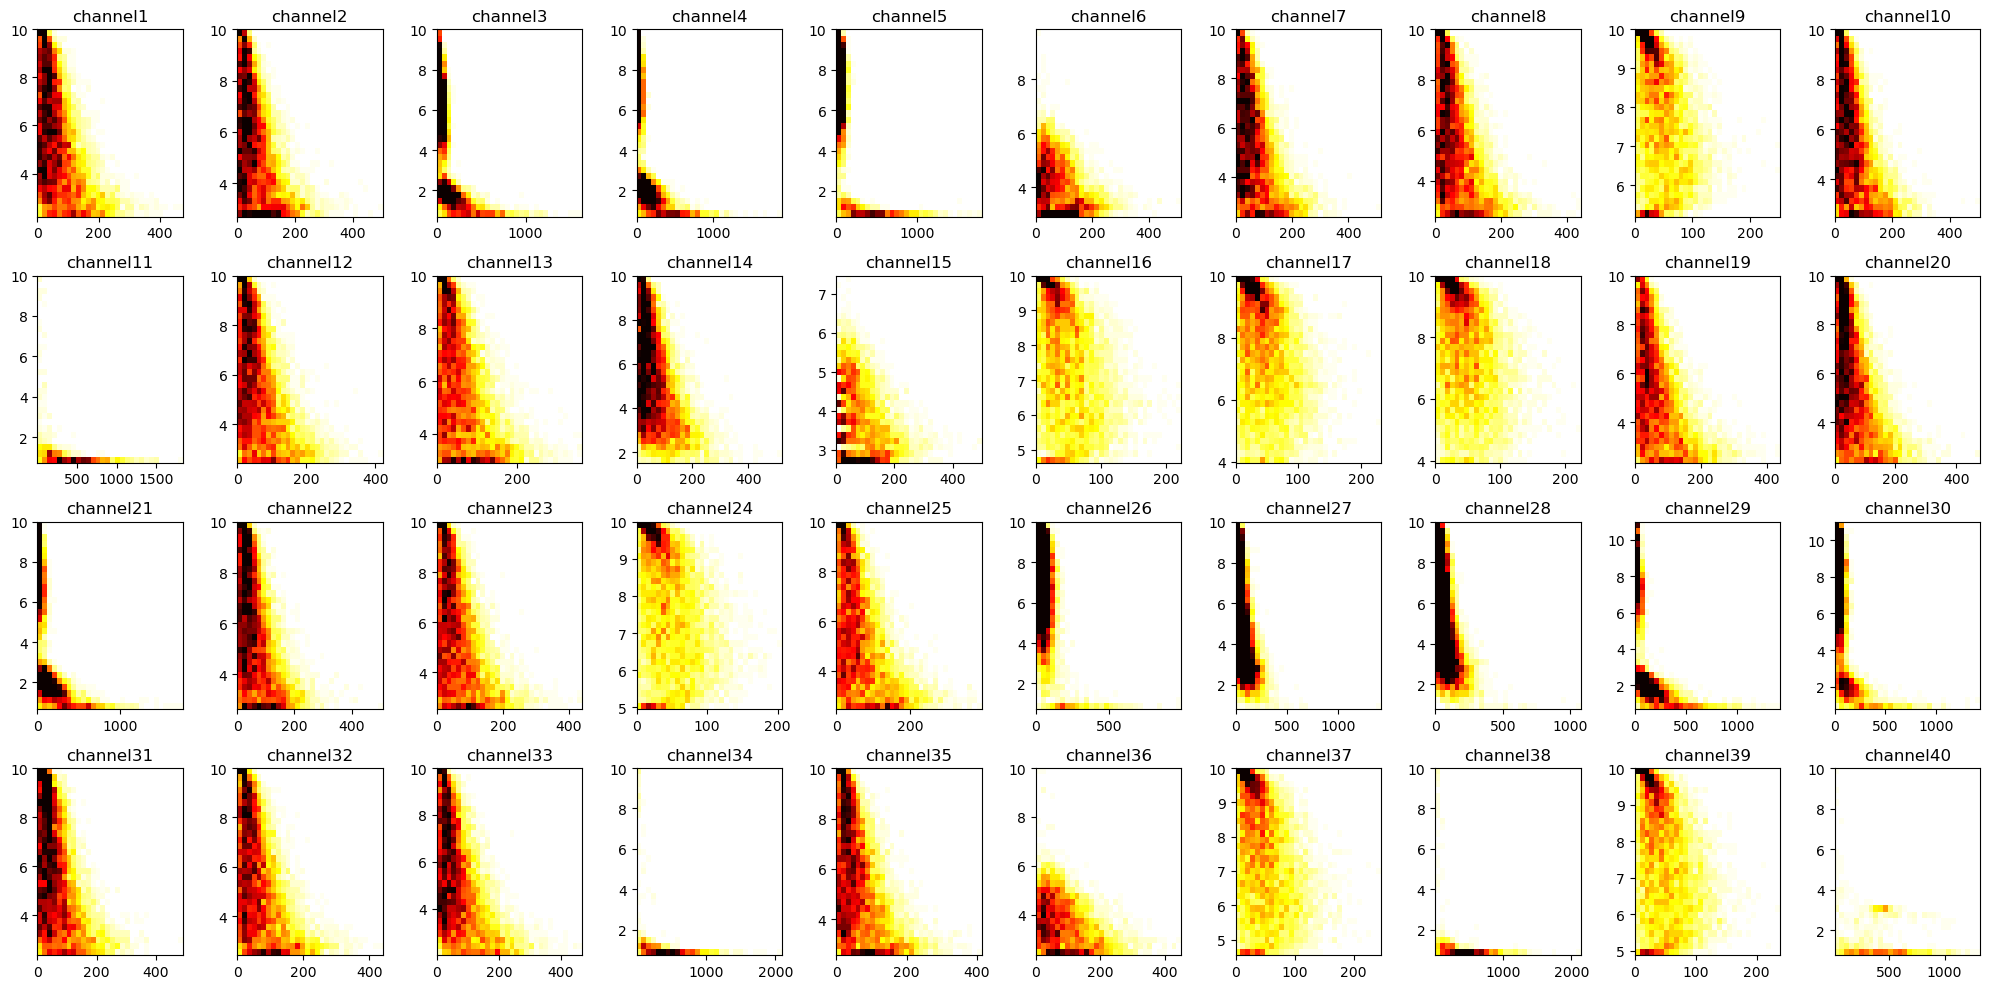

In [56]:
plt.figure(figsize=(20, 10))
for i in range(40):
    plt.subplot(4, 10, i + 1)
    plt.hist2d(
        features_slow[i][2], features_slow[i][3], bins=(30, 30), cmap="hot_r", vmax=60
    );
    plt.title(channels[i])
plt.tight_layout()

ValueError: autodetected range of [nan, nan] is not finite

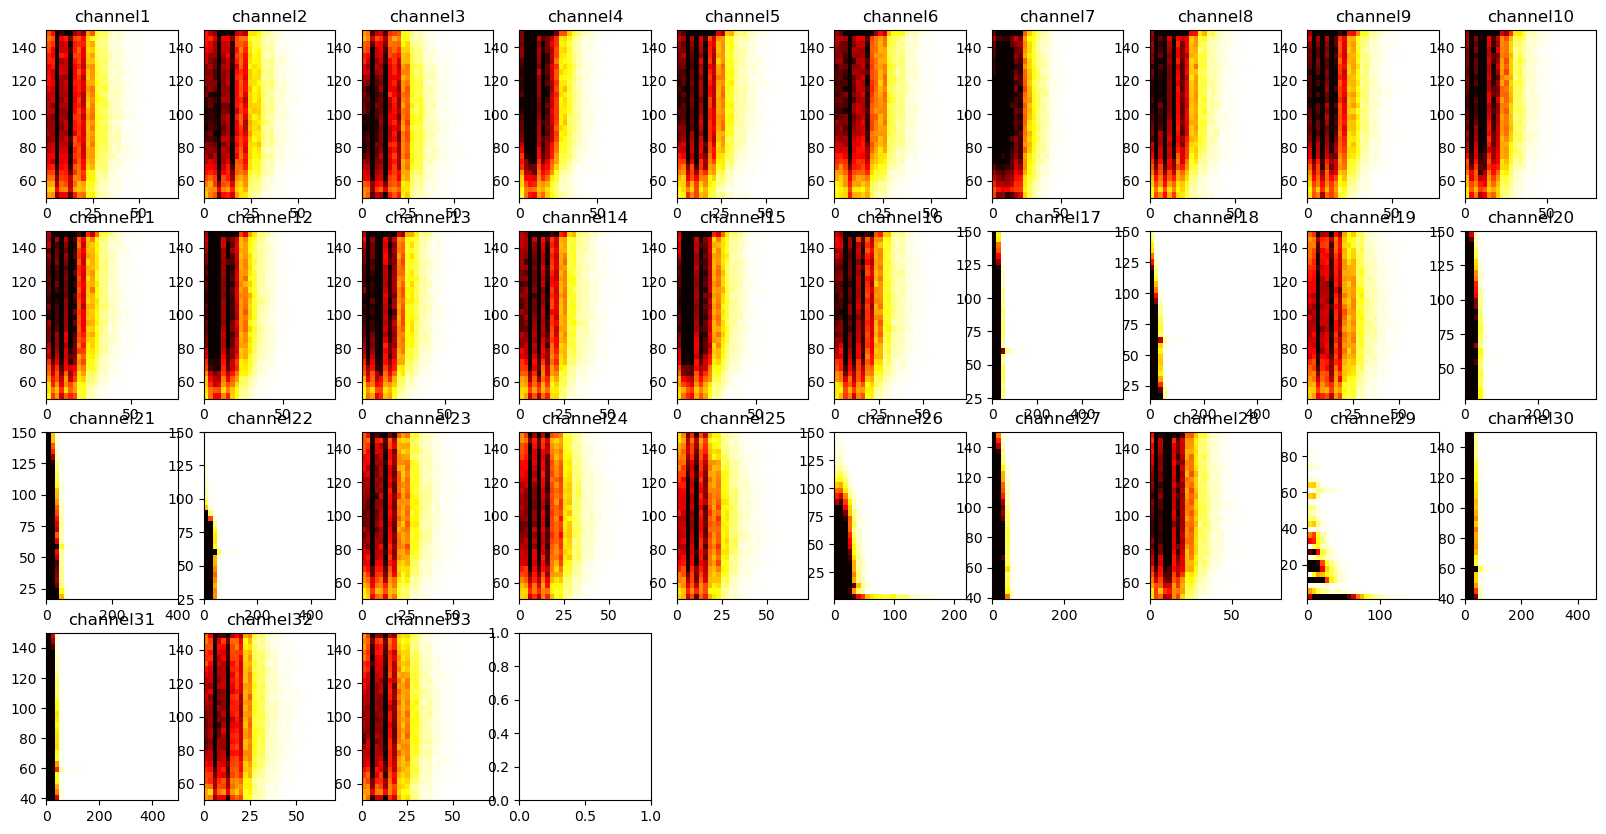

In [63]:
plt.figure(figsize=(20, 10))
for i in range(40):
    plt.subplot(4, 10, i + 1)
    plt.hist2d(
        features_fast[i][2], features_fast[i][3], bins=(30, 30), cmap="hot_r", vmax=500
    );
    plt.title(channels[i])
plt.tight_layout()

In [ ]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.svm import SVC

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data, colors, test_size=0.2, random_state=42)

# Create the SVM classifier
svm_classifier = SVC(kernel='linear')

# Perform cross-validation on the training data
cv_scores = cross_val_score(svm_classifier, X_train, y_train, cv=5, n_jobs=20)  # 5-fold cross-validation

# Print the cross-validation scores
print("Cross-Validation Scores:", cv_scores)

# Train the SVM classifier on the entire training data
svm_classifier.fit(X_train, y_train)

# Evaluate the classifier on the test set
test_accuracy = svm_classifier.score(X_test, y_test)
print("Test Accuracy:", test_accuracy)

In [9]:
bursts = xr.concat(bursts, "channels")

In [10]:
bursts = bursts.interpolate_na(dim="freqs", method="nearest")

In [11]:
bursts = bursts.fillna(0)

In [12]:
win, twin = define_windows(bursts.freqs.data, sfreq=1, slwin_len=30)
bursts_cg = []
for wi, wf in win:
    bursts_cg += [bursts[:, wi:wf, :].any(axis=1)]

Defining temporal windows (sfreq=1)
    Definition of sliding windows (len=30, start=0.6547716483876248, stop=11.0, step=30.040923228024226)


In [13]:
bursts = (
    xr.concat(bursts_cg, "freqs")
    .assign_coords({"freqs": twin})
    .transpose("channels", "freqs", "times")
)

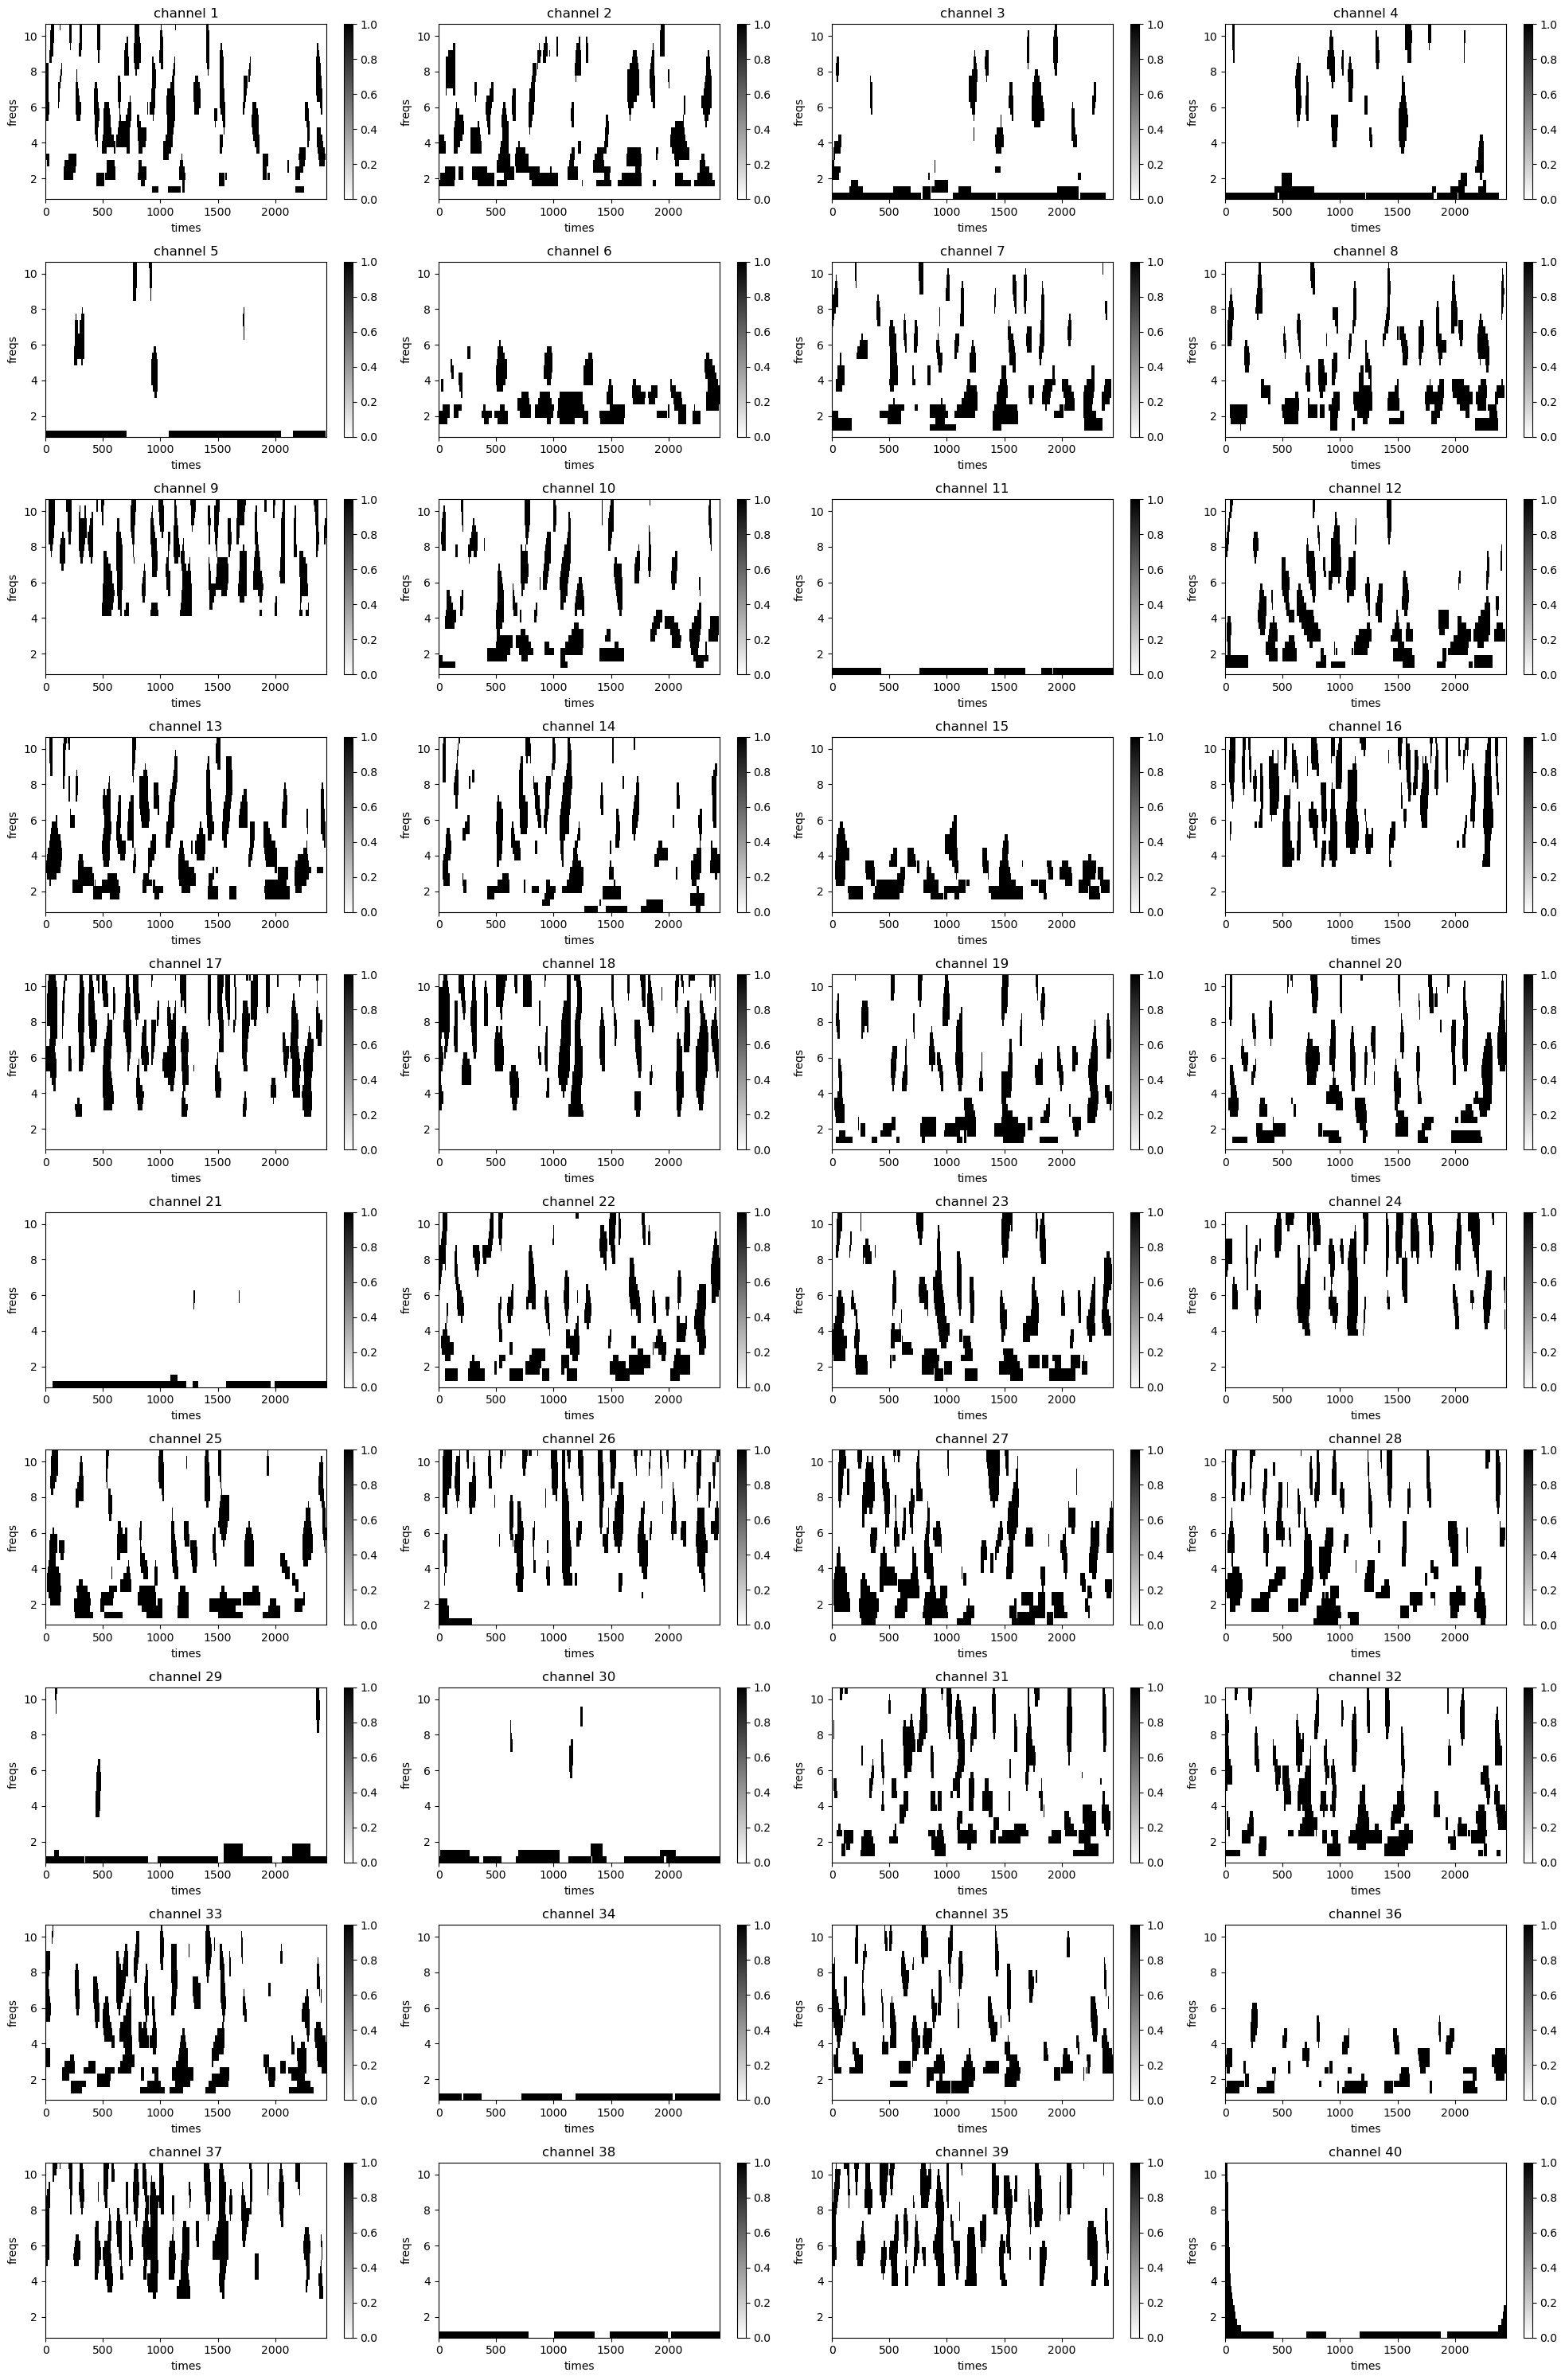

In [14]:
plt.figure(figsize=(20, 30))
for i in range(len(channels)):
    plt.subplot(10, 4, i + 1)
    (bursts[i]).plot.imshow(cmap="binary")
    plt.title(f"channel {i + 1}")
plt.tight_layout()
impath = f"figures/{monkey}/{date}/"
plt.savefig(os.path.join(impath, "bursts.png"))

In [18]:
labeled3D, _, _ = return_labeled_image(bursts.data, 0)

In [21]:
unique, counts = np.unique(labeled3D, return_counts=True)

In [32]:
unique[counts > 6000][1:].shape

(12,)

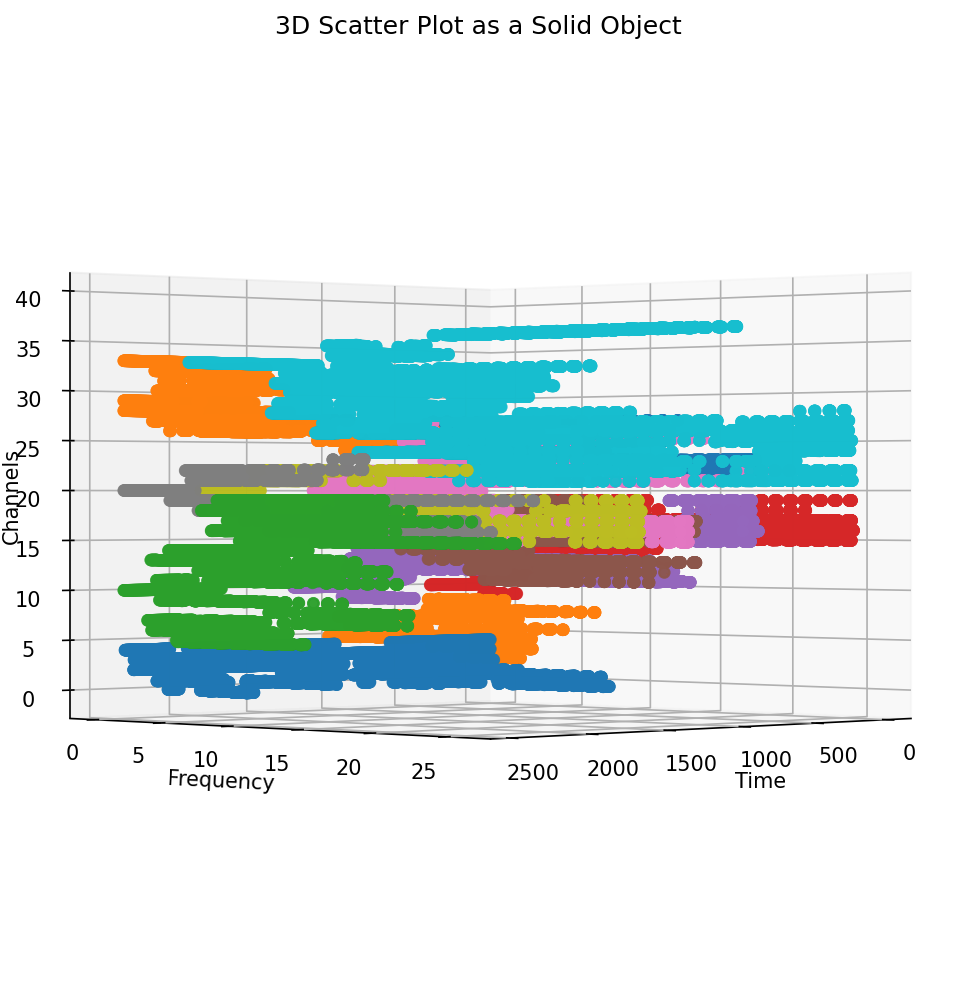

In [35]:
nonzero_coords = np.transpose(np.nonzero(labeled3D > 0))

# Visualize the 3D matrix
fig = plt.figure(figsize=(8, 8), dpi=150)
ax = fig.add_subplot(111, projection="3d")

# Scatter plot for each non-zero element
ax.scatter(
    nonzero_coords[:, 2],
    nonzero_coords[:, 1],
    nonzero_coords[:, 0],
    c="b",
    marker="o",
    s=0,
)
# Set labels and title
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.set_title("3D Scatter Plot as a Solid Object")
ax.set_zlabel("Channels", labelpad=-5)


cmap = plt.get_cmap("turbo")
for l in unique[counts > 6000][1:]:
    x, y, z = np.where(labeled3D == l)
    color = cmap(l / labeled3D.max())
    ax.scatter(z, y, x, marker=".", label=f"l={l}", s=100)
ax.set_xlabel("Time")
ax.set_ylabel("Frequency")
ax.set_zlabel("Channels", labelpad=-5)
ax.view_init(elev=0, azim=45)